# Creating cloud optimized reference files with earthaccess and virtualizarr
This notebook will focus on the usage of `earthaccess.open_virtual_dataset` and `earthaccess.open_virtual_mfdataset` to create cloud optimized reference files for the data stored in the cloud.

All of the examples in this tutorial load data over https (`access="indirect"`). However, there is a **significant** speed improvement when using these functions in-cloud and enabling `access="direct"`. For example, using managed cloud JupyterHubs like NASA VEDA or 2i2c Openscapes. This is because the data is streamed directly from cloud storage to cloud compute.

> WARNING: This feature is current experimental and may change in the future. This feature relies on NASA DMR++ metadata files which may not always be present for your dataset and you may get a `FileNotFoundError`.


In [1]:
import earthaccess
import xarray as xr

In [2]:
# NASA JPL Multiscale Ultrahigh Resolution (MUR) Sea Surface Temperature (SST) dataset - 0.01 degree resolution
results = earthaccess.search_data(
    temporal=("2010-01-01", "2010-01-31"), short_name="MUR-JPL-L4-GLOB-v4.1"
)
len(results)

32

In [3]:
%%time
mur = earthaccess.open_virtual_mfdataset(
    results,
    access="indirect",
    load=True,
    concat_dim="time",
    coords="all",
    compat="override",
    combine_attrs="drop_conflicts",
)
mur

CPU times: user 1.37 s, sys: 189 ms, total: 1.55 s
Wall time: 17.6 s


<xarray.Dataset> Size: 581GB
Dimensions:           (time: 32, lat: 17999, lon: 36000)
Coordinates:
  * lat               (lat) float32 72kB -89.99 -89.98 -89.97 ... 89.98 89.99
  * lon               (lon) float32 144kB -180.0 -180.0 -180.0 ... 180.0 180.0
  * time              (time) datetime64[ns] 256B 2010-01-01T09:00:00 ... 2010...
Data variables:
    analysed_sst      (time, lat, lon) float64 166GB dask.array<chunksize=(1, 1023, 2047), meta=np.ndarray>
    analysis_error    (time, lat, lon) float64 166GB dask.array<chunksize=(1, 1023, 2047), meta=np.ndarray>
    mask              (time, lat, lon) float32 83GB dask.array<chunksize=(1, 1447, 2895), meta=np.ndarray>
    sea_ice_fraction  (time, lat, lon) float64 166GB dask.array<chunksize=(1, 1447, 2895), meta=np.ndarray>
Attributes: (12/42)
    Conventions:                CF-1.5
    title:                      Daily MUR SST, Final product
    summary:                    A merged, multi-sensor L4 Foundation SST anal...
    references:                 http://podaac.jpl.nasa.gov/Multi-scale_Ultra-...
    institution:                Jet Propulsion Laboratory
    history:                    created at nominal 4-day latency; replaced nr...
    ...                         ...
    project:                    NASA Making Earth Science Data Records for Us...
    publisher_name:             GHRSST Project Office
    publisher_url:              http://www.ghrsst.org
    publisher_email:            ghrsst-po@nceo.ac.uk
    processing_level:           L4
    cdm_data_type:              grid

In [4]:
print(f"{mur.nbytes / 1e9} GB")

580.575960252 GB


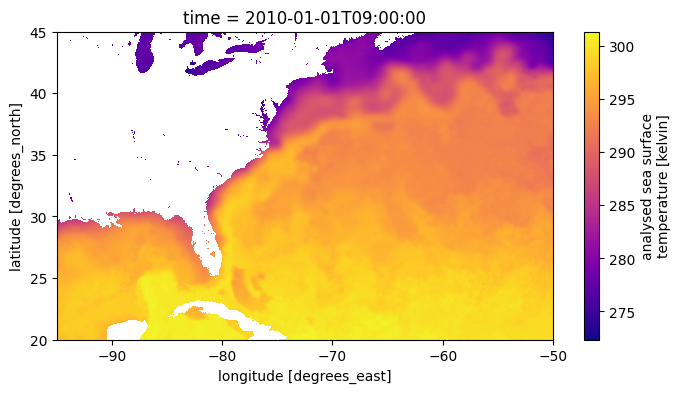

In [24]:
mur.isel(time=0).sel(
    lat=slice(20, 45), lon=slice(-95, -50)
).analysed_sst.plot.pcolormesh(x="lon", y="lat", cmap="plasma", figsize=(8, 4))

## Save virtual reference file and load with xarray
If you have a dataset you frequently access or you want to share this blueprint file with others, it is recommended to create a virtual reference file that points to the data in the cloud. This allows xarray to rapidly load the dataset as if it was a [Zarr store](https://zarr.dev/).

Notice below that `load=False`. This means that the output of `open_virtual_mfdataset` is a virtual xarray Dataset that contains only chunk information and metadata. You can modify this dataset, then save it to a virtual reference file (as JSON), and then simply load that file with xarray. For more information on virtual reference files, see the [virtualizarr documentation](https://virtualizarr.readthedocs.io/en/latest/).

Sample workflow:
1. Open a dataset with `open_virtual_mfdataset` with `load=False`
2. Modify the dataset as needed
3. Save the dataset to a virtual reference file with `vds.virtualize.to_kerchunk(...)`
4. Load the virtual reference file with `xr.open_dataset(..., engine='kerchunk')`

In [5]:
%%time
mur_vds = earthaccess.open_virtual_mfdataset(
    results,
    access="indirect",
    load=False,
    concat_dim="time",
    coords="all",
    compat="override",
    combine_attrs="drop_conflicts",
)
mur_vds

CPU times: user 481 ms, sys: 50.4 ms, total: 531 ms
Wall time: 6.87 s


<xarray.Dataset> Size: 124GB
Dimensions:           (time: 32, lat: 17999, lon: 36000)
Coordinates:
    time              (time) int32 128B ManifestArray<shape=(32,), dtype=int3...
    lat               (lat) float32 72kB ManifestArray<shape=(17999,), dtype=...
    lon               (lon) float32 144kB ManifestArray<shape=(36000,), dtype...
Data variables:
    mask              (time, lat, lon) int8 21GB ManifestArray<shape=(32, 179...
    sea_ice_fraction  (time, lat, lon) int8 21GB ManifestArray<shape=(32, 179...
    analysed_sst      (time, lat, lon) int16 41GB ManifestArray<shape=(32, 17...
    analysis_error    (time, lat, lon) int16 41GB ManifestArray<shape=(32, 17...
Attributes: (12/42)
    Conventions:                CF-1.5
    title:                      Daily MUR SST, Final product
    summary:                    A merged, multi-sensor L4 Foundation SST anal...
    references:                 http://podaac.jpl.nasa.gov/Multi-scale_Ultra-...
    institution:                Jet Propulsion Laboratory
    history:                    created at nominal 4-day latency; replaced nr...
    ...                         ...
    project:                    NASA Making Earth Science Data Records for Us...
    publisher_name:             GHRSST Project Office
    publisher_url:              http://www.ghrsst.org
    publisher_email:            ghrsst-po@nceo.ac.uk
    processing_level:           L4
    cdm_data_type:              grid

In [6]:
# Example of what's inside this virtual dataset
print(mur_vds.analysed_sst.data.zarray)
print(mur_vds.analysed_sst.data.manifest.dict()["0.0.1"])

ZArray(shape=(32, 17999, 36000), chunks=(1, 1023, 2047), dtype=dtype('int16'), fill_value=-32768, order='C', compressor=None, filters=[{'id': 'shuffle', 'elementsize': 2}, {'id': 'zlib', 'level': 6}], zarr_format=2)
{'path': 'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20100101090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc', 'offset': 44835, 'length': 4083}


In [7]:
mur_vds.virtualize.to_kerchunk(filepath="mur_kerchunk.json", format="json")

In [23]:
%%time
fs = earthaccess.get_fsspec_https_session()
ds = xr.open_dataset(
    "reference://",
    engine="zarr",
    chunks={},
    backend_kwargs={
        "consolidated": False,
        "storage_options": {
            "fo": "mur_kerchunk.json",
            "remote_protocol": fs.protocol,
            "remote_options": fs.storage_options,
        },
    },
)
print(ds)

<xarray.Dataset> Size: 581GB
Dimensions:           (time: 32, lat: 17999, lon: 36000)
Coordinates:
  * lat               (lat) float32 72kB -89.99 -89.98 -89.97 ... 89.98 89.99
  * lon               (lon) float32 144kB -180.0 -180.0 -180.0 ... 180.0 180.0
  * time              (time) datetime64[ns] 256B 2010-01-01T09:00:00 ... 2010...
Data variables:
    analysed_sst      (time, lat, lon) float64 166GB dask.array<chunksize=(1, 1023, 2047), meta=np.ndarray>
    analysis_error    (time, lat, lon) float64 166GB dask.array<chunksize=(1, 1023, 2047), meta=np.ndarray>
    mask              (time, lat, lon) float32 83GB dask.array<chunksize=(1, 1447, 2895), meta=np.ndarray>
    sea_ice_fraction  (time, lat, lon) float64 166GB dask.array<chunksize=(1, 1447, 2895), meta=np.ndarray>
Attributes: (12/42)
    Conventions:                CF-1.5
    title:                      Daily MUR SST, Final product
    summary:                    A merged, multi-sensor L4 Foundation SST anal...
    references:

## Read datasets with groups

In [9]:
# NASA TEMPO NO2 tropospheric and stratospheric columns V03
results = earthaccess.search_data(count=2, doi="10.5067/IS-40e/TEMPO/NO2_L2.003")
len(results)

2

In [10]:
earthaccess.open_virtual_dataset(results[0], group="product")

<xarray.Dataset> Size: 7MB
Dimensions:                                  (mirror_step: 123, xtrack: 2048)
Dimensions without coordinates: mirror_step, xtrack
Data variables:
    main_data_quality_flag                   (mirror_step, xtrack) int16 504kB ManifestArray<shape=(123, 2048), dtype=int16, chunks=(123, 2048...
    vertical_column_troposphere              (mirror_step, xtrack) float64 2MB ManifestArray<shape=(123, 2048), dtype=float64, chunks=(123, 2048...
    vertical_column_stratosphere             (mirror_step, xtrack) float64 2MB ManifestArray<shape=(123, 2048), dtype=float64, chunks=(123, 2048...
    vertical_column_troposphere_uncertainty  (mirror_step, xtrack) float64 2MB ManifestArray<shape=(123, 2048), dtype=float64, chunks=(123, 2048...

## Advanced: Preprocess the datasets
You can also preprocess the datasets before saving the virtual reference file. This is useful if you want to apply a function to the datasets before concatentaion. For example, the `SWOT_L2_LR_SSH_Expert_2.0` dataset (from [NASA JPL SWOT satellite](https://www.jpl.nasa.gov/missions/surface-water-and-ocean-topography-swot/)) is an [L2 product](https://www.earthdata.nasa.gov/learn/earth-observation-data-basics/data-processing-levels) where each file represents a single pass of the satellite. If you want to combine all the passes into a single dataset, you can concatenate the datasets using `cycle_number` and `pass_number` which are only found in the attributes of each netcdf file.

The `preprocess` function and argument allows us to turn those attributes into dimensions first, and then concatenate along this new dimension.

In [11]:
results = earthaccess.search_data(
    count=10, temporal=("2023"), short_name="SWOT_L2_LR_SSH_Expert_2.0"
)

In [12]:
%%time


def preprocess(ds: xr.Dataset) -> xr.Dataset:
    # Add cycle number and pass_number as dimensions
    return ds.expand_dims(["cycle_num", "pass_num"]).assign_coords(
        cycle_num=[ds.attrs["cycle_number"]], pass_num=[ds.attrs["pass_number"]]
    )


swot = earthaccess.open_virtual_mfdataset(
    results,
    access="indirect",
    load=False,
    preprocess=preprocess,
    concat_dim="pass_num",
    coords="all",
    compat="override",
    combine_attrs="drop_conflicts",
)
swot

CPU times: user 489 ms, sys: 75.1 ms, total: 564 ms
Wall time: 6.96 s


<xarray.Dataset> Size: 1GB
Dimensions:                                (cycle_num: 1, pass_num: 10,
                                            num_lines: 9866, num_pixels: 69,
                                            num_sides: 2)
Coordinates:
    longitude                              (pass_num, num_lines, num_pixels) int32 27MB ManifestArray<shape=(10, 9866, 69), dtype=int32, chunks=(1,...
    latitude                               (pass_num, num_lines, num_pixels) int32 27MB ManifestArray<shape=(10, 9866, 69), dtype=int32, chunks=(1,...
    latitude_nadir                         (pass_num, num_lines) int32 395kB ...
    longitude_nadir                        (pass_num, num_lines) int32 395kB ...
  * cycle_num                              (cycle_num) int64 8B 1
  * pass_num                               (pass_num) int64 80B 149 150 ... 158
Dimensions without coordinates: num_lines, num_pixels, num_sides
Data variables: (12/98)
    height_cor_xover_qual                  (cycle_num, pass_num, num_lines, num_pixels) uint8 7MB ManifestArray<shape=(1, 10, 9866, 69), dtype=uint8, chu...
    swh_ssb_cor_source                     (cycle_num, pass_num, num_lines, num_pixels) uint8 7MB ManifestArray<shape=(1, 10, 9866, 69), dtype=uint8, chu...
    rain_rate                              (cycle_num, pass_num, num_lines, num_pixels) uint8 7MB ManifestArray<shape=(1, 10, 9866, 69), dtype=uint8, chu...
    dynamic_ice_flag                       (cycle_num, pass_num, num_lines, num_pixels) uint8 7MB ManifestArray<shape=(1, 10, 9866, 69), dtype=uint8, chu...
    orbit_qual                             (cycle_num, pass_num, num_lines) uint8 99kB ManifestArray<shape=(1, 10, 9866), dtype=uint8, chunks=(1,...
    ancillary_surface_classification_flag  (cycle_num, pass_num, num_lines, num_pixels) uint8 7MB ManifestArray<shape=(1, 10, 9866, 69), dtype=uint8, chu...
    ...                                     ...
    sig0_cor_atmos_model                   (cycle_num, pass_num, num_lines, num_pixels) float32 27MB ManifestArray<shape=(1, 10, 9866, 69), dtype=float32, ...
    cross_track_distance                   (cycle_num, pass_num, num_lines, num_pixels) float32 27MB ManifestArray<shape=(1, 10, 9866, 69), dtype=float32, ...
    sig0_karin_uncert                      (cycle_num, pass_num, num_lines, num_pixels) float32 27MB ManifestArray<shape=(1, 10, 9866, 69), dtype=float32, ...
    time                                   (cycle_num, pass_num, num_lines) float64 789kB ManifestArray<shape=(1, 10, 9866), dtype=float64, chunks=...
    time_tai                               (cycle_num, pass_num, num_lines) float64 789kB ManifestArray<shape=(1, 10, 9866), dtype=float64, chunks=...
    polarization_karin                     (cycle_num, pass_num, num_lines, num_sides) object 2MB ManifestArray<shape=(1, 10, 9866, 2), dtype=object, ch...
Attributes: (12/29)
    Conventions:                      CF-1.7
    title:                            Level 2 Low Rate Sea Surface Height Dat...
    institution:                      JPL
    source:                           Ka-band radar interferometer
    platform:                         SWOT
    reference_document:               D-56407_SWOT_Product_Description_L2_LR_SSH
    ...                               ...
    xref_pole_location_file:          SMM_PO1_AXXCNE20231122_020000_19900101_...
    xref_wave_model_files:            SMM_WMA_AXPCNE20230727_072014_20230726_...
    xref_geco_database_version:       v102
    ellipsoid_semi_major_axis:        6378137.0
    ellipsoid_flattening:             0.0033528106647474805
    references:                       V1.2.1